# Chap02 End-to-End Machine Learning Project

Your task is to predict median house values in Californian districts, given a number of features from these districts.


In [1]:
# Common imports
import numpy as np
import pandas as pd
import seaborn as sns

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
# Load the data
housing = pd.read_csv("../data/housing.csv")
housing.head()


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


total_bedrooms      20433 non-null  float64， 207 districts are missing this feature.

 ocean_proximity     20640 non-null  object ，we can research this feature to find out how many categories there are.


In [4]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

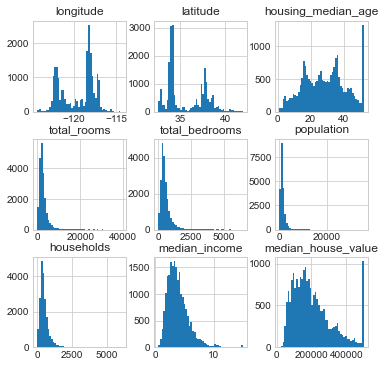

In [6]:
# pd histogram: a quick way to get a feel of the type of data 
# you are dealing with is to plot a histogram for each numerical attribute.
housing.hist(bins=50,figsize=(6,6))
plt.show()

In [7]:
labels = list(housing.iloc[:,i].name for i in range(0,9))

In [8]:
# # Xs = [] is not suggested
# Xs = []
# for i in range(0,9):
#     x = housing.iloc[:,i]
#     Xs.append(x)
#     labels = list(housing.iloc[:,i].name)

In [9]:
len(housing.columns[:-1])

9

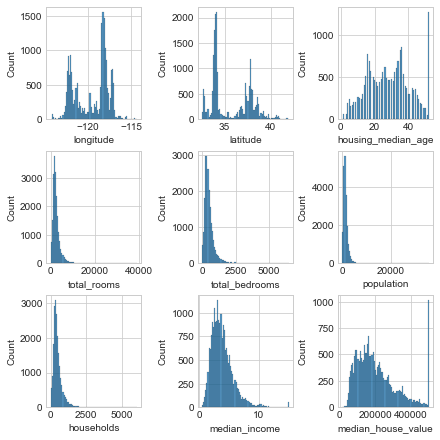

In [10]:
_, axes = plt.subplots(3, 3, figsize=(6, 6),constrained_layout=True)

for ax, col in zip(axes.flatten(), housing.columns[:-1]):
    sns.histplot(data=housing, x=col, bins=80, ax=ax)

$$\text{Figure 2-8. A histogram for each numerical attribute}$$


**There** are a few things you might notice in these histograms:

1. First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the **data has been scaled and capped at 15** (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000). Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.

2. **The housing median age and the median house value were also capped**. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit.You need to check with your client team (the team that will use your system’s out‐put) to see if this is a problem or not. If they tell you that they need precise predictions even beyond $500,000, then you have two options:
        

- Collect proper labels for the districts whose labels were capped.

- **Remove those districts from the training set** (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).

3. These attributes have very different scales. 
        

4. Finally, **many histograms are tail-heavy:** they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distribution


## Create a Test Set


In [11]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2,random_state=42)


In [13]:

test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20046    -119.01     36.06                25.0       1505.0             NaN   
3024     -119.46     35.14                30.0       2943.0             NaN   
15663    -122.44     37.80                52.0       3830.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   
9814     -121.93     36.62                34.0       2351.0             NaN   

       population  households  median_income  median_house_value  \
20046      1392.0       359.0         1.6812             47700.0   
3024       1565.0       584.0         2.5313             45800.0   
15663      1310.0       963.0         3.4801            500001.0   
20484      1705.0       495.0         5.7376            218600.0   
9814       1063.0       428.0         3.7250            278000.0   

      ocean_proximity  
20046          INLAND  
3024           INLAND  
15663        NEAR BAY  
20484       <1H OCEAN  
9814       NEAR OCEAN

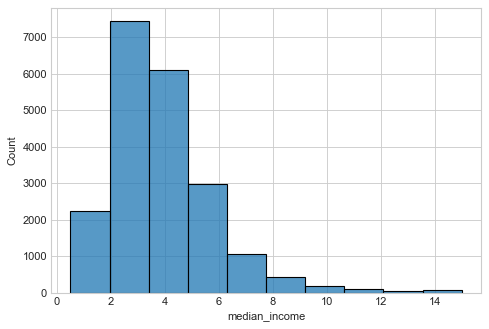

In [14]:
_, ax = plt.subplots(figsize=(6, 4), dpi=80,constrained_layout=True)

sns.histplot(data=housing, x='median_income', bins=10, ax=ax)
plt.show()

In Figure 2-8: 

* Most median income values are clustered around 1.5 to 6 (i.e., $15, 000–$60, 000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased. 

* This means that you should not have too many strata, and each stratum should be large enough. The following code uses the pd.cut() function to create an income category attribute with five categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15, 000), category 2 from 1.5 to 3, and so on.
* However, we do not need to statify sampling every dataset, finllay we  will compare the preformance of **Sampling methods**, (e.g, Overall, Stratified and Random sampling methods), in order to determine whether we need the stratified sampling or NOT.

#### Strata sampling


In [15]:
bins_In = [0, 1.5, 3, 4.5, 6, np.inf]  # np.inf= infinity
labels_In = [1, 2, 3, 4, 5]

housing["income_categories"] = pd.cut(
    housing["median_income"], bins=bins_In, labels=labels_In
)


In [16]:
housing['income_categories'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_categories, dtype: int64

<AxesSubplot:>

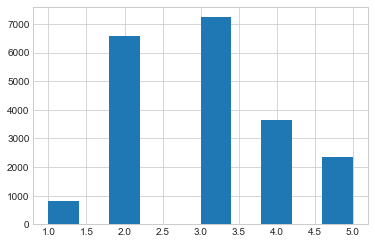

In [17]:
housing['income_categories'].hist()

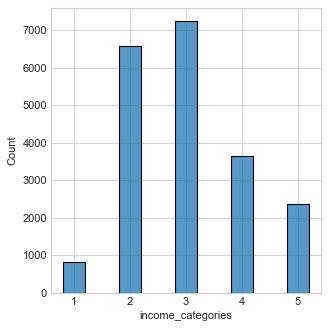

In [18]:
_, ax = plt.subplots(figsize=(4, 4), dpi=80, constrained_layout=True)

sns.histplot(housing["income_categories"], bins=10, shrink=0.4, ax=ax)
plt.show()


#### Go on stratified sampling with StratifiedShuffleSplit


In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing,
                                           housing["income_categories"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [20]:
# Compare the stratify sampling with the overall sampling

# strat_test_set['income_categories'].value_counts() / len(strat_test_set)
# housing['income_categories'].value_counts() / len(housing)

# Of course we can make a dataframe
# to compare all the three sampling methods:

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

mthds = ['Overall','Stratified','Random']
dfs = [housing,strat_test_set,test_set]

compare_props = []

for i in range(3):
    incom_cat_props = dfs[i]["income_categories"].value_counts() / len(dfs[i])
    compare_props.append(incom_cat_props)

compare_props = pd.DataFrame(compare_props).T.set_axis(mthds, axis=1, inplace=False)

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

Overall  Stratified    Random  Rand. %error  Strat. %error
3  0.350581    0.350533  0.358527      2.266446      -0.013820
2  0.318847    0.318798  0.324370      1.732260      -0.015195
4  0.176308    0.176357  0.167393     -5.056334       0.027480
5  0.114438    0.114583  0.109496     -4.318374       0.127011
1  0.039826    0.039729  0.040213      0.973236      -0.243309

As you can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is skewed.


#### We spent quite a bit of time on test set generation **for a good reason**:

 - This is an often neglected but ritical part of a Machine Learning project. 
 
- Moreover, many of these ideas will be useful later when we discuss crossvalidation. 

## Discover and Visualize the Data to Gain Insights


If the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. 

In our case, the set is quite small, so you can just work directly on the full set. Let’s create a copy so that you can play with it without harming the training set:

In [21]:
housing = strat_train_set.copy()

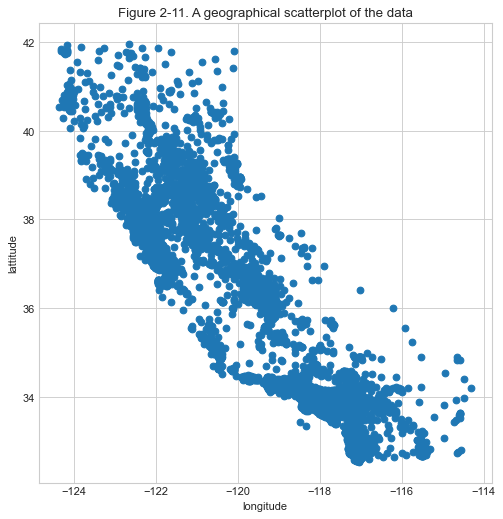

In [22]:
_, ax = plt.subplots(figsize=(6,6), dpi=80, constrained_layout=True)

ax.scatter(data=housing, x="longitude", y="latitude")
plt.savefig('./img/2.11_bad_visualization_plot.png')
ax.set(xlabel='longitude',ylabel='lattitude',
       title="Figure 2-11. A geographical scatterplot of the data")
plt.show()

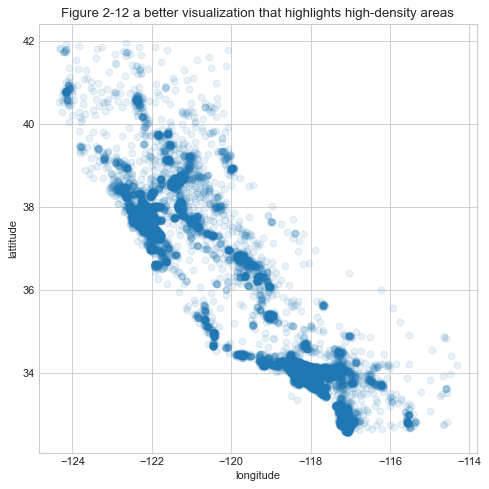

In [23]:
_, ax = plt.subplots(figsize=(6, 6), dpi=80, constrained_layout=True)

ax.scatter(data=housing, x="longitude", y="latitude",alpha = 0.1)
ax.set(xlabel='longitude',ylabel='lattitude',
       title='Figure 2-12 a better visualization that highlights high-density areas')
plt.savefig('./img/2.12_better_visualization_plot.png')
plt.show()

Now that’s much better: you can clearly see the high-density areas.

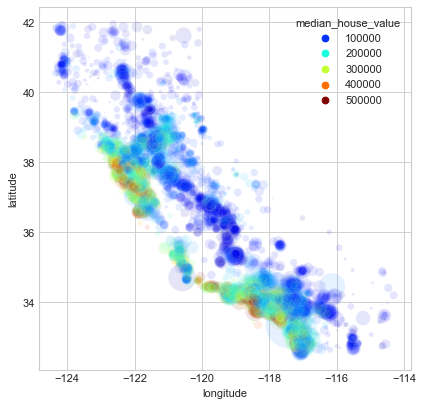

In [24]:
_, ax = plt.subplots(figsize=(6, 6), dpi=80)

sns.set_context(font_scale=2)

g = sns.scatterplot(data=housing, 
                    x="longitude", y="latitude",
                   alpha=0.1,ax=ax,
                   hue="median_house_value",#for colors below
                    s=housing["population"] / 20,
                    palette=plt.get_cmap("jet"))
plt.savefig('./img/2.12.5_better_colors_visualization_plot.png')
plt.show()

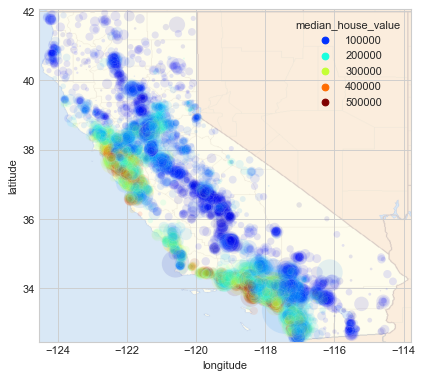

In [25]:
# Now intro Cali map jpeg
import matplotlib.image as mpimg

california_img = mpimg.imread('./img/california.png')

_, ax = plt.subplots(figsize=(6,6), dpi=80)

sns.set_context(font_scale=2)

g = sns.scatterplot(data=housing, 
                    x="longitude", y="latitude",
                   alpha=0.1,ax=ax,
                   hue="median_house_value",#for colors below
                    s=housing["population"] / 20,
                    palette=plt.get_cmap("jet"))

# Now for cal map:
ax.imshow(california_img,alpha=0.4,
          extent=[-124.55, -113.80, 32.45, 42.05],
          cmap=plt.get_cmap("jet")
         )
plt.savefig('./img/2.13_Cali_housing_prices.png')
plt.show()

## Looking for Correlations

Since the dataset is not too large, you can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using the corr() method

In [26]:
corr_matrix = housing.corr()
corr_matrix

longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924478           -0.105848     0.048871   
latitude            -0.924478  1.000000            0.005766    -0.039184   
housing_median_age  -0.105848  0.005766            1.000000    -0.364509   
total_rooms          0.048871 -0.039184           -0.364509     1.000000   
total_bedrooms       0.076598 -0.072419           -0.325047     0.929379   
population           0.108030 -0.115222           -0.298710     0.855109   
households           0.063070 -0.077647           -0.306428     0.918392   
median_income       -0.019583 -0.075205           -0.111360     0.200087   
median_house_value  -0.047432 -0.142724            0.114110     0.135097   

                    total_bedrooms  population  households  median_income  \
longitude                 0.076598    0.108030    0.063070      -0.019583   
latitude                 -0.072419   -0.115222   -0.077647      -0.075205   
housing_median_age       -0.325047   -0.298710   -0.306428      -0.111360   
total_rooms               0.929379    0.855109    0.918392       0.200087   
total_bedrooms            1.000000    0.876320    0.980170      -0.009740   
population                0.876320    1.000000    0.904637       0.002380   
households                0.980170    0.904637    1.000000       0.010781   
median_income            -0.009740    0.002380    0.010781       1.000000   
median_house_value        0.047689   -0.026920    0.064506       0.687160   

                    median_house_value  
longitude                    -0.047432  
latitude                     -0.142724  
housing_median_age            0.114110  
total_rooms                   0.135097  
total_bedrooms                0.047689  
population                   -0.026920  
households                    0.064506  
median_income                 0.687160  
median_house_value            1.000000

In [27]:
midHval = corr_matrix["median_house_value"].sort_values(ascending=False)

In [28]:
attrs = midHval.index[0:4]
attrs

Index(['median_house_value', 'median_income', 'total_rooms',
       'housing_median_age'],
      dtype='object')

Now we can see there are correlations among:

    median_house_value    1.000000
    median_income         0.687160
    total_rooms           0.135097
    housing_median_age    0.114110

So plot a corr matrix by sns:

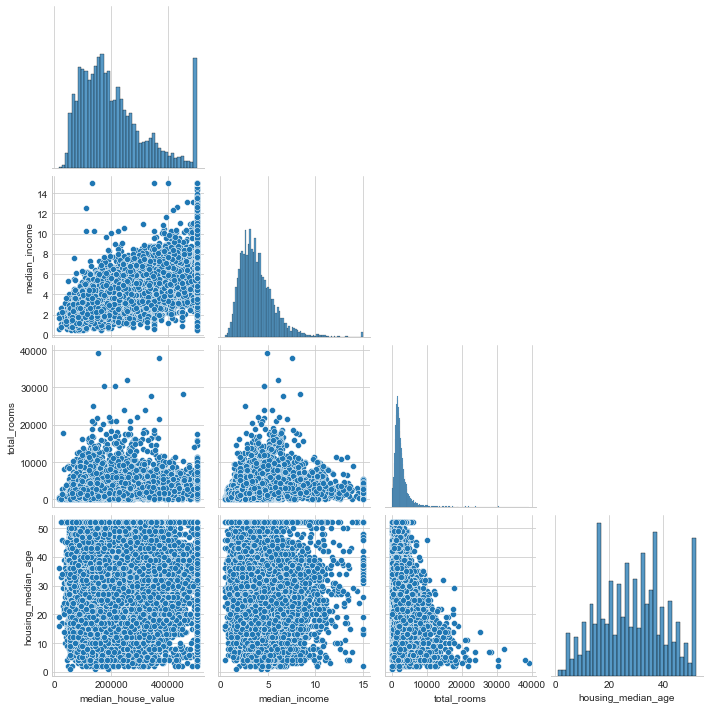

In [29]:

g = sns.pairplot(housing[attrs],
                 corner=True)

plt.show()
# very slow take it easy

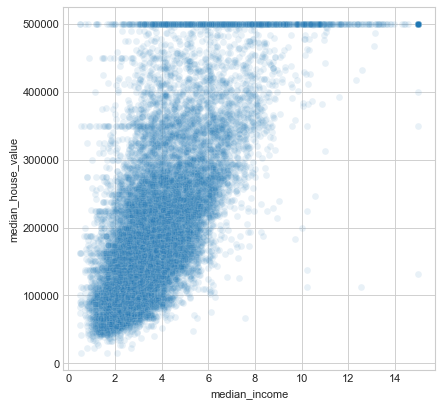

In [30]:
_, ax = plt.subplots(figsize=(6, 6), dpi=80)

g = sns.scatterplot(data=housing, 
                   x="median_income", y="median_house_value",
                   alpha=0.1,ax=ax)
plt.show()

This plot reveals a few things:

- First, the correlation is indeed very strong; you can clearly see the upward trend, and the points are not too dispersed. 

- Second, the price cap that we noticed earlier is clearly visible as a horizontal line at $500,000. 

- **However, This plot reveals other less obvious straight lines**: 

a horizontal line around 450,000 dollars, another around 350,000 dollars perhaps one around $280,000, and a few more below that.

**You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.**


### Dataprep library

In [31]:
from dataprep import eda

In [32]:
# check missing values
housing.isnull().mean() 

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        0.009569
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
income_categories     0.000000
dtype: float64

  0%|                                                   | 0/153 [00:00<?, ?it/s]


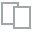
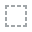
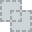
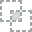
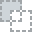
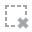
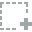
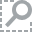
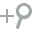
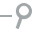
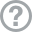
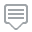
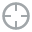
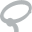
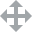
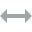
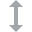
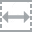
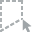
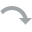
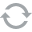
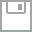
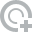
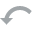
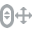
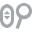
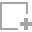
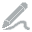
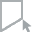
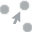
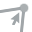
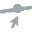

In [33]:
eda.plot_missing(housing)

100%|#####################################################| 4/4 [00:00<?, ?it/s]


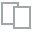
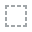
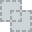
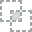
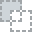
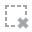
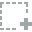
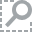
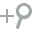
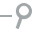
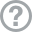
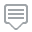
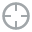
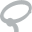
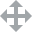
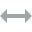
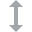
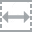
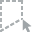
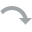
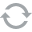
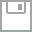
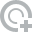
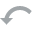
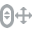
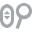
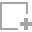
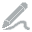
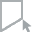
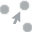
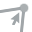
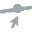

In [34]:
# correlation plot:
eda.plot_correlation(housing)

In [35]:
housing_corr = housing.corr()
housing_corr["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [36]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  median_house_value  \
17606       710.0       339.0         2.7042            286600.0   
18632       306.0       113.0         6.4214            340600.0   
14650       936.0       462.0         2.8621            196900.0   
3230       1460.0       353.0         1.8839             46300.0   
3555       4459.0      1463.0         3.0347            254500.0   

      ocean_proximity income_categories  
17606       <1H OCEAN                 2  
18632       <1H OCEAN                 5  
14650      NEAR OCEAN                 2  
3230           INLAND                 2  
3555        <1H OCEAN                 3

In [37]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing[
    "bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing[
    "population_per_household"] = housing["population"] / housing["households"]

In [38]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  median_house_value  \
17606       710.0       339.0         2.7042            286600.0   
18632       306.0       113.0         6.4214            340600.0   
14650       936.0       462.0         2.8621            196900.0   
3230       1460.0       353.0         1.8839             46300.0   
3555       4459.0      1463.0         3.0347            254500.0   

      ocean_proximity income_categories  rooms_per_household  \
17606       <1H OCEAN                 2             4.625369   
18632       <1H OCEAN                 5             6.008850   
14650      NEAR OCEAN                 2             4.225108   
3230           INLAND                 2             5.232295   
3555        <1H OCEAN                 3             4.505810   

       bedrooms_per_room  population_per_household  
17606           0.223852                  2.094395  
18632           0.159057                  2.707965  
14650           0.241291                  2.025974  
3230            0.200866                  4.135977  
3555            0.231341                  3.047847

In [39]:
housing_corr = housing.corr()# new features
housing_corr

longitude  latitude  housing_median_age  \
longitude                  1.000000 -0.924478           -0.105848   
latitude                  -0.924478  1.000000            0.005766   
housing_median_age        -0.105848  0.005766            1.000000   
total_rooms                0.048871 -0.039184           -0.364509   
total_bedrooms             0.076598 -0.072419           -0.325047   
population                 0.108030 -0.115222           -0.298710   
households                 0.063070 -0.077647           -0.306428   
median_income             -0.019583 -0.075205           -0.111360   
median_house_value        -0.047432 -0.142724            0.114110   
rooms_per_household       -0.028345  0.107621           -0.147186   
bedrooms_per_room          0.095603 -0.116884            0.136788   
population_per_household  -0.000410  0.005420            0.015031   

                          total_rooms  total_bedrooms  population  households  \
longitude                    0.048871        0.076598    0.108030    0.063070   
latitude                    -0.039184       -0.072419   -0.115222   -0.077647   
housing_median_age          -0.364509       -0.325047   -0.298710   -0.306428   
total_rooms                  1.000000        0.929379    0.855109    0.918392   
total_bedrooms               0.929379        1.000000    0.876320    0.980170   
population                   0.855109        0.876320    1.000000    0.904637   
households                   0.918392        0.980170    0.904637    1.000000   
median_income                0.200087       -0.009740    0.002380    0.010781   
median_house_value           0.135097        0.047689   -0.026920    0.064506   
rooms_per_household          0.127519        0.000377   -0.074692   -0.083009   
bedrooms_per_room           -0.192606        0.086960    0.037778    0.067162   
population_per_household    -0.024810       -0.028370    0.076225   -0.027416   

                          median_income  median_house_value  \
longitude                     -0.019583           -0.047432   
latitude                      -0.075205           -0.142724   
housing_median_age            -0.111360            0.114110   
total_rooms                    0.200087            0.135097   
total_bedrooms                -0.009740            0.047689   
population                     0.002380           -0.026920   
households                     0.010781            0.064506   
median_income                  1.000000            0.687160   
median_house_value             0.687160            1.000000   
rooms_per_household            0.311563            0.146285   
bedrooms_per_room             -0.624674           -0.259984   
population_per_household       0.021822           -0.021985   

                          rooms_per_household  bedrooms_per_room  \
longitude                           -0.028345           0.095603   
latitude                             0.107621          -0.116884   
housing_median_age                  -0.147186           0.136788   
total_rooms                          0.127519          -0.192606   
total_bedrooms                       0.000377           0.086960   
population                          -0.074692           0.037778   
households                          -0.083009           0.067162   
median_income                        0.311563          -0.624674   
median_house_value                   0.146285          -0.259984   
rooms_per_household                  1.000000          -0.398546   
bedrooms_per_room                   -0.398546           1.000000   
population_per_household            -0.005314           0.004279   

                          population_per_household  
longitude                                -0.000410  
latitude                                  0.005420  
housing_median_age                        0.015031  
total_rooms                              -0.024810  
total_bedrooms                           -0.028370  
population                                0.076225 

In [40]:
housing_corr["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [41]:
housing.columns[-3:]

Index(['rooms_per_household', 'bedrooms_per_room', 'population_per_household'], dtype='object')

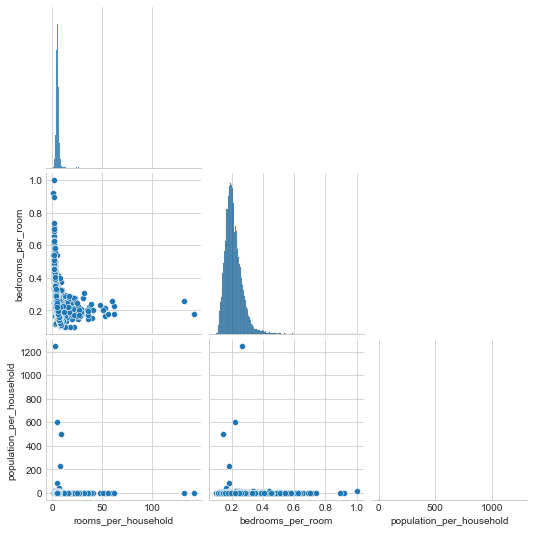

In [42]:
attrs_per = housing.columns[-3:]

g = sns.pairplot(housing[attrs_per],corner=True)

In [43]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  16512.000000  16512.000000        16512.000000  16512.000000   
mean    -119.575834     35.639577           28.653101   2622.728319   
std        2.001860      2.138058           12.574726   2138.458419   
min     -124.350000     32.540000            1.000000      6.000000   
25%     -121.800000     33.940000           18.000000   1443.000000   
50%     -118.510000     34.260000           29.000000   2119.500000   
75%     -118.010000     37.720000           37.000000   3141.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    16354.000000  16512.000000  16512.000000   16512.000000   
mean       534.973890   1419.790819    497.060380       3.875589   
std        412.699041   1115.686241    375.720845       1.904950   
min          2.000000      3.000000      2.000000       0.499900   
25%        295.000000    784.000000    279.000000       2.566775   
50%        433.000000   1164.000000    408.000000       3.540900   
75%        644.000000   1719.250000    602.000000       4.744475   
max       6210.000000  35682.000000   5358.000000      15.000100   

       median_house_value  rooms_per_household  bedrooms_per_room  \
count        16512.000000         16512.000000       16354.000000   
mean        206990.920724             5.440341           0.212878   
std         115703.014830             2.611712           0.057379   
min          14999.000000             1.130435           0.100000   
25%         119800.000000             4.442040           0.175304   
50%         179500.000000             5.232284           0.203031   
75%         263900.000000             6.056361           0.239831   
max         500001.000000           141.909091           1.000000   

       population_per_household  
count              16512.000000  
mean                   3.096437  
std                   11.584826  
min                    0.692308  
25%                    2.431287  
50%                    2.817653  
75%                    3.281420  
max                 1243.333333

## Prepare the data for Machine Learning algorithms

### Revert to a clean training set (by copying strat_train_set once again).

In [44]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

Data Cleaning Most Machine Learning algorithms cannot work with missing features。 We saw earlier that the total_bedrooms attribute has some missing values, so let’s fix this. You have three options:

1. Get rid of the corresponding districts.
    - housing.dropna(subset=["total_bedrooms"])    `# option 1` 
2. Get rid of the whole attribute.
    - housing.drop("total_bedrooms", axis=1)       `# option 2`
3. Set the values to some value (zero, the mean, the median, etc.).
      - median = housing["total_bedrooms"].median()   `# option 3` 
      - housing["total_bedrooms"].fillna(median, inplace=True)

In [45]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)]

In [46]:
sample_incomplete_rows.shape

(158, 10)

In [47]:
sample_incomplete_rows.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0             NaN   
6068     -117.86     34.01                16.0       4632.0             NaN   
17923    -121.97     37.35                30.0       1955.0             NaN   
13656    -117.30     34.05                 6.0       2155.0             NaN   
19252    -122.79     38.48                 7.0       6837.0             NaN   

       population  households  median_income ocean_proximity income_categories  
4629       3296.0      1462.0         2.2708       <1H OCEAN                 2  
6068       3038.0       727.0         5.1762       <1H OCEAN                 4  
17923       999.0       386.0         4.6328       <1H OCEAN                 4  
13656      1039.0       391.0         1.6675          INLAND                 2  
19252      3468.0      1405.0         3.1662       <1H OCEAN                 3

In [48]:
# total_bedrooms = nan, drop
# option 1:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity, income_categories]
Index: []

In [49]:
sample_incomplete_rows.shape

(158, 10)

In [50]:
sample_incomplete_rows.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0             NaN   
6068     -117.86     34.01                16.0       4632.0             NaN   
17923    -121.97     37.35                30.0       1955.0             NaN   
13656    -117.30     34.05                 6.0       2155.0             NaN   
19252    -122.79     38.48                 7.0       6837.0             NaN   

       population  households  median_income ocean_proximity income_categories  
4629       3296.0      1462.0         2.2708       <1H OCEAN                 2  
6068       3038.0       727.0         5.1762       <1H OCEAN                 4  
17923       999.0       386.0         4.6328       <1H OCEAN                 4  
13656      1039.0       391.0         1.6675          INLAND                 2  
19252      3468.0      1405.0         3.1662       <1H OCEAN                 3

In [51]:
# option 2
sample_incomplete_rows.drop("total_bedrooms",axis=1)

longitude  latitude  housing_median_age  total_rooms  population  \
4629     -118.30     34.07                18.0       3759.0      3296.0   
6068     -117.86     34.01                16.0       4632.0      3038.0   
17923    -121.97     37.35                30.0       1955.0       999.0   
13656    -117.30     34.05                 6.0       2155.0      1039.0   
19252    -122.79     38.48                 7.0       6837.0      3468.0   
...          ...       ...                 ...          ...         ...   
3376     -118.28     34.25                29.0       2559.0      1886.0   
4691     -118.37     34.07                50.0       2519.0      1117.0   
6052     -117.76     34.04                34.0       1914.0      1564.0   
17198    -119.75     34.45                 6.0       2864.0      1404.0   
4738     -118.38     34.05                49.0        702.0       458.0   

       households  median_income ocean_proximity income_categories  
4629       1462.0         2.2708       <1H OCEAN                 2  
6068        727.0         5.1762       <1H OCEAN                 4  
17923       386.0         4.6328       <1H OCEAN                 4  
13656       391.0         1.6675          INLAND                 2  
19252      1405.0         3.1662       <1H OCEAN                 3  
...           ...            ...             ...               ...  
3376        769.0         2.6036       <1H OCEAN                 2  
4691        516.0         4.3667       <1H OCEAN                 3  
6052        328.0         2.8347          INLAND                 2  
17198       603.0         5.5073      NEAR OCEAN                 4  
4738        187.0         4.8958       <1H OCEAN                 4  

[158 rows x 9 columns]

In [52]:
#option 3
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

/usr/local/Caskroom/miniconda/base/envs/p39/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [53]:
sample_incomplete_rows.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0           433.0   
6068     -117.86     34.01                16.0       4632.0           433.0   
17923    -121.97     37.35                30.0       1955.0           433.0   
13656    -117.30     34.05                 6.0       2155.0           433.0   
19252    -122.79     38.48                 7.0       6837.0           433.0   

       population  households  median_income ocean_proximity income_categories  
4629       3296.0      1462.0         2.2708       <1H OCEAN                 2  
6068       3038.0       727.0         5.1762       <1H OCEAN                 4  
17923       999.0       386.0         4.6328       <1H OCEAN                 4  
13656      1039.0       391.0         1.6675          INLAND                 2  
19252      3468.0      1405.0         3.1662       <1H OCEAN                 3

Scikit-Learn provides a handy class to take care of missing values: `SimpleImputer`:

In [54]:
from sklearn.impute import SimpleImputer

# create a SimpleImputer instance, 
# specifying that you want to replace each attribute’s missing values 
# with the median of that attribute:

imputer = SimpleImputer(strategy="median")

In [55]:
# Since the median can only be computed on numerical attributes, 
# you need to create a copy of the data.
# without the text attribute ocean_proximity:

housing_num = housing.drop("ocean_proximity",axis=1)

In [56]:
# fit the imputer instance to the training data using the fit() method
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [57]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [58]:
housing_num.median().values

/var/folders/1q/m8l_wvxd5dl8kccgv4xrsxtr0000gn/T/ipykernel_79407/3605723347.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  housing_num.median().values


array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

`imputer.statistics_` and `housing_num.median().values` are equal right?
Ok, what is the replacing method again? Try `strategy`

In [59]:
imputer.strategy

'median'

Use this “trained” imputer to transform the training set **by replacing missing values with the learned medians**:

In [60]:
X = imputer.transform(housing_num)

In [61]:
housing_tr = pd.DataFrame(X,
                          columns=housing_num.columns,
                          index=housing_num.index)

In [62]:
housing_tr.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  income_categories  
17606       710.0       339.0         2.7042                2.0  
18632       306.0       113.0         6.4214                5.0  
14650       936.0       462.0         2.8621                2.0  
3230       1460.0       353.0         1.8839                2.0  
3555       4459.0      1463.0         3.0347                3.0

In [63]:
housing_tr.loc[sample_incomplete_rows.index.values]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0           433.0   
6068     -117.86     34.01                16.0       4632.0           433.0   
17923    -121.97     37.35                30.0       1955.0           433.0   
13656    -117.30     34.05                 6.0       2155.0           433.0   
19252    -122.79     38.48                 7.0       6837.0           433.0   
...          ...       ...                 ...          ...             ...   
3376     -118.28     34.25                29.0       2559.0           433.0   
4691     -118.37     34.07                50.0       2519.0           433.0   
6052     -117.76     34.04                34.0       1914.0           433.0   
17198    -119.75     34.45                 6.0       2864.0           433.0   
4738     -118.38     34.05                49.0        702.0           433.0   

       population  households  median_income  income_categories  
4629       3296.0      1462.0         2.2708                2.0  
6068       3038.0       727.0         5.1762                4.0  
17923       999.0       386.0         4.6328                4.0  
13656      1039.0       391.0         1.6675                2.0  
19252      3468.0      1405.0         3.1662                3.0  
...           ...         ...            ...                ...  
3376       1886.0       769.0         2.6036                2.0  
4691       1117.0       516.0         4.3667                3.0  
6052       1564.0       328.0         2.8347                2.0  
17198      1404.0       603.0         5.5073                4.0  
4738        458.0       187.0         4.8958                4.0  

[158 rows x 9 columns]

Issue:Why there is a "income_categories" col which is absent from the original code?
so get rid of this column firstly.




In [64]:
housing_tr = housing_tr.drop("income_categories",axis=1)


In [65]:
housing_tr.shape

(16512, 8)

### Handling Text and Categorical Attributes

In [66]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
19480          INLAND
8879        <1H OCEAN
13685          INLAND
4937        <1H OCEAN
4861        <1H OCEAN

In [67]:
housing_cat.value_counts()
# woo~~~ somebody bought islands!

ocean_proximity
<1H OCEAN          7276
INLAND             5263
NEAR OCEAN         2124
NEAR BAY           1847
ISLAND                2
dtype: int64

In [68]:
from sklearn.preprocessing import OrdinalEncoder


Convert these categories from text to numbers. For this, we can use Scikit-Learn’s `OrdinalEncoder`

In [69]:

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded

array([[0.],
       [0.],
       [4.],
       ...,
       [1.],
       [0.],
       [3.]])

In [70]:
ordinal_encoder.categories_
# I like the housing_cat.value_counts()

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [71]:
from sklearn.preprocessing import OneHotEncoder

Create one binary attribute per category with on-hot encoding,by`OneHotEncoder`

In [72]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [73]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [74]:
col_1hot = cat_encoder.categories_

ALso we can [convert the sparse matrix to a pd.DataFrame:](https://stackoverflow.com/questions/59339820/convert-a-numpy-float64-sparse-matrix-to-a-pandas-data-frame)

In [75]:
hotdf = pd.DataFrame(housing_cat_1hot.toarray(),columns=col_1hot)
hotdf.head()

<1H OCEAN INLAND ISLAND NEAR BAY NEAR OCEAN
0       1.0    0.0    0.0      0.0        0.0
1       1.0    0.0    0.0      0.0        0.0
2       0.0    0.0    0.0      0.0        1.0
3       0.0    1.0    0.0      0.0        0.0
4       1.0    0.0    0.0      0.0        0.0

In [76]:
# also again, dummmies help us:
pd.get_dummies(housing_cat).head(15)

ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
17606                          1                       0   
18632                          1                       0   
14650                          0                       0   
3230                           0                       1   
3555                           1                       0   
19480                          0                       1   
8879                           1                       0   
13685                          0                       1   
4937                           1                       0   
4861                           1                       0   
16365                          0                       1   
19684                          0                       1   
19234                          1                       0   
13956                          0                       1   
2390                           0                       1   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
17606                       0                         0   
18632                       0                         0   
14650                       0                         0   
3230                        0                         0   
3555                        0                         0   
19480                       0                         0   
8879                        0                         0   
13685                       0                         0   
4937                        0                         0   
4861                        0                         0   
16365                       0                         0   
19684                       0                         0   
19234                       0                         0   
13956                       0                         0   
2390                        0                         0   

       ocean_proximity_NEAR OCEAN  
17606                           0  
18632                           0  
14650                           1  
3230                            0  
3555                            0  
19480                           0  
8879                            0  
13685                           0  
4937                            0  
4861                            0  
16365                           0  
19684                           0  
19234                           0  
13956                           0  
2390                            0

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [77]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [78]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Create a  **custom transformer** to add extra attributes:

Custom Transformers:

- Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn func‐tionalities (such as pipelines), and since Scikit-Learn relies on **[duck typing](https://en.wikipedia.org/wiki/Duck_typing)** (not inher‐itance), all you need to do is create a class and implement three methods: fit() (returning self), transform(), and fit_transform().


You can get the last one for free by simply adding TransformerMixin as a base class.
If you add BaseEstimator as a base class (and avoid \*args and \**kargs in your con‐structor),you will also get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning.
For example, here is a small transformer class that adds the combined attributes we discussed earlier:

In [153]:
# now remember:
housing_tr.iloc[:,3:7].head(3)
# dowbelow: rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

total_rooms  total_bedrooms  population  households
17606       1568.0           351.0       710.0       339.0
18632        679.0           108.0       306.0       113.0
14650       1952.0           471.0       936.0       462.0

In [80]:
from sklearn.base import BaseEstimator, TransformerMixin

In [81]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin): 
    def __init__(self, add_bedrooms_per_room = True): 
        # no *args or **kargs 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None): 
        return self
        
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room: 
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [82]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In this example the transformer has one hyperparameter, add_bedrooms_per_room, set to **True** by default (it is often helpful to provide sensible defaults).This hyperpara‐meter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. 

More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time).

With this customized transformer,let's move on to the:
### Transformation Pipelines.

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [84]:


num_pipeline = Pipeline([
                    ('imputer',SimpleImputer(strategy="median")),
                    ('attribs_adder',CombinedAttributesAdder()),
                    ('std_scaler', StandardScaler()),
    
])

In [85]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [86]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

#### full_pipeline

In [87]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                        ("num_pipline", num_pipeline,num_attribs),
                        ("cat_pipeline", OneHotEncoder(),cat_attribs),
    
])

housing_prepared = full_pipeline.fit_transform(housing)

In [88]:
# just check, not for model training
pd.DataFrame(housing_prepared)

0         1         2         3         4         5         6   \
0     -1.156043  0.771950  0.743331 -0.493234 -0.445438 -0.636211 -0.420698   
1     -1.176025  0.659695 -1.165317 -0.908967 -1.036928 -0.998331 -1.022227   
2      1.186849 -1.342183  0.186642 -0.313660 -0.153345 -0.433639 -0.093318   
3     -0.017068  0.313576 -0.290520 -0.362762 -0.396756  0.036041 -0.383436   
4      0.492474 -0.659299 -0.926736  1.856193  2.412211  2.724154  2.570975   
...         ...       ...       ...       ...       ...       ...       ...   
16507  0.722267 -0.673331  1.379547 -0.632123 -0.725361 -0.759010 -0.764049   
16508  1.007011 -0.823004  0.902385 -0.667196 -0.584183 -0.329664 -0.636291   
16509  1.586489 -0.724781 -1.562952  1.043901  0.822735  0.607904  0.713156   
16510  0.782213 -0.851068  0.186642 -0.309919 -0.374849 -0.057178 -0.375451   
16511 -1.435791  0.996459  1.856709  0.220853  0.360253 -0.135159  0.377791   

             7         8         9         10        11   12   13   14   15  \
0     -0.614937 -0.954456 -0.312055 -0.086499  0.155318  1.0  0.0  0.0  0.0   
1      1.336459  1.890305  0.217683 -0.033534 -0.836289  1.0  0.0  0.0  0.0   
2     -0.532046 -0.954456 -0.465315 -0.092405  0.422200  0.0  0.0  0.0  0.0   
3     -1.045566 -0.954456 -0.079661  0.089736 -0.196453  0.0  1.0  0.0  0.0   
4     -0.441437 -0.006202 -0.357834 -0.004194  0.269928  1.0  0.0  0.0  0.0   
...         ...       ...       ...       ...       ...  ...  ...  ...  ...   
16507  0.554158  0.942051  0.234352 -0.031755 -0.428853  0.0  1.0  0.0  0.0   
16508 -0.948815 -0.954456 -0.308114  0.084689  0.491503  0.0  1.0  0.0  0.0   
16509 -0.316705 -0.006202  0.346934 -0.030554 -0.521776  0.0  1.0  0.0  0.0   
16510  0.098121 -0.006202  0.024995  0.061509 -0.303407  1.0  0.0  0.0  0.0   
16511 -0.157799 -0.006202 -0.228529 -0.095863  0.101806  0.0  0.0  0.0  1.0   

        16  
0      0.0  
1      0.0  
2      1.0  
3      0.0  
4      0.0  
...    ...  
16507  0.0  
16508  0.0  
16509  0.0  
16510  0.0  
16511  0.0  

[16512 rows x 17 columns]

In [89]:
num_attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'income_categories']

In [90]:
cat_attribs

['ocean_proximity']

In [91]:
housing_prepared.shape

(16512, 17)

In [92]:
housing_labels.shape

(16512,)

### Select and train a model

#### LinearRegression

In [93]:
from sklearn.linear_model import LinearRegression

In [94]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression()

In [95]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print(f'Predictions: {lin_reg.predict(some_data_prepared)};\n Lables: {list(some_labels)}.')


Predictions: [203682.37379543 326371.39370781 204218.64588245  58685.4770482
 194213.06443039];
 Lables: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0].


In [96]:
# check
pd.DataFrame(some_data_prepared)

0         1         2         3         4         5         6   \
0 -1.156043  0.771950  0.743331 -0.493234 -0.445438 -0.636211 -0.420698   
1 -1.176025  0.659695 -1.165317 -0.908967 -1.036928 -0.998331 -1.022227   
2  1.186849 -1.342183  0.186642 -0.313660 -0.153345 -0.433639 -0.093318   
3 -0.017068  0.313576 -0.290520 -0.362762 -0.396756  0.036041 -0.383436   
4  0.492474 -0.659299 -0.926736  1.856193  2.412211  2.724154  2.570975   

         7         8         9         10        11   12   13   14   15   16  
0 -0.614937 -0.954456 -0.312055 -0.086499  0.155318  1.0  0.0  0.0  0.0  0.0  
1  1.336459  1.890305  0.217683 -0.033534 -0.836289  1.0  0.0  0.0  0.0  0.0  
2 -0.532046 -0.954456 -0.465315 -0.092405  0.422200  0.0  0.0  0.0  0.0  1.0  
3 -1.045566 -0.954456 -0.079661  0.089736 -0.196453  0.0  1.0  0.0  0.0  0.0  
4 -0.441437 -0.006202 -0.357834 -0.004194  0.269928  1.0  0.0  0.0  0.0  0.0

Let’s measure this regression model’s RMSE on the whole training set using `ScikitLearn’s mean_squared_error()` function:

In [97]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [98]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_mae = mean_absolute_error(housing_labels,housing_predictions)

print(f'With Linear Regression Model,The Mean Squared Error is {lin_rmse},\n The Mean Absolute Error is {lin_mae}') 

With Linear Regression Model,The Mean Squared Error is 68376.64295459939,
 The Mean Absolute Error is 49508.082059709115


This is an example of a model **underfitting** the training data.

#### DecisionTreeRegression

Here comes the `DecisionTreeRegressor` models:

In [99]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [100]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [101]:
# 0.0....just like a nerd looking at you

##### Better Evaluation Using Cross-Validation

In [102]:
# Scikit-Learn’s K-fold cross-validation feature
from sklearn.model_selection import cross_val_score

In [103]:
scores = cross_val_score(tree_reg,housing_prepared,housing_labels,
                         scoring="neg_mean_squared_error",cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [104]:
# book method:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)

Scores: [70274.7991723  67258.3624668  71350.42593227 68882.91340979
 70987.99296566 74177.52037059 70788.57311306 70850.53018019
 76430.62239321 70212.6471067 ]
Mean: 71121.4387110585
Standard deviation: 2434.3080046605132


In [105]:
# Or:
print(f'Scores:{tree_rmse_scores},\n Mean:{tree_rmse_scores.mean()}, \n Standard deviation: {tree_rmse_scores.std()}')

Scores:[70274.7991723  67258.3624668  71350.42593227 68882.91340979
 70987.99296566 74177.52037059 70788.57311306 70850.53018019
 76430.62239321 70212.6471067 ],
 Mean:71121.4387110585, 
 Standard deviation: 2434.3080046605132


Compute the same scores for the Linear Regression model

In [106]:
lin_scores = cross_val_score(lin_reg, housing_prepared,housing_labels,
                            scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [66877.52325028 66608.120256   70575.91118868 74179.94799352
 67683.32205678 71103.16843468 64782.65896552 67711.29940352
 71080.40484136 67687.6384546 ]
Mean: 68828.99948449328
Standard deviation: 2662.761570610338


#### RandomForestRegression

Compute the same scores for `RandomForestRegressor`

In [107]:
from sklearn.ensemble import RandomForestRegressor

In [108]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [109]:
housing_predictions = forest_reg.predict(housing_prepared)# .predict!
forest_mse = mean_squared_error(housing_labels,housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18626.45217719628

In [110]:
forest_scores = cross_val_score(forest_reg,housing_prepared,housing_labels,
                                scoring="neg_mean_squared_error",cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49633.454487   47565.18736589 50034.52343496 52444.25008076
 49463.18392461 53515.10766804 48577.59023701 47678.90315126
 53433.75372939 49947.64462367]
Mean: 50229.359870258486
Standard deviation: 2082.3174179664184


#### Support Vector Regression

In [111]:
from sklearn.svm import SVR

In [112]:
svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)

In [113]:
svm_mse = mean_squared_error(housing_labels,housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

106874.50415237379

In [114]:
svm_scores = cross_val_score(svm_reg,housing_prepared,housing_labels,
                                scoring="neg_mean_squared_error",cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [101753.54978461 108380.51380685 106200.32161595 109301.66402916
 106682.29073341 111849.88610827 106534.44353941 110576.7797446
 109867.22584371 107754.78897031]
Mean: 107890.14641762718
Standard deviation: 2699.4020751918697


### Fine Tune Model

In [115]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [116]:
param_distribs = {
                'n_estimators':randint(low=1,high=200),
                'max_features':randint(low=1,high=8),
}

forest_reg = RandomForestRegressor(random_state=200)
rnd_search = RandomizedSearchCV(forest_reg,
                                param_distributions=param_distribs,
                                n_iter=10,cv=5,
                                scoring='neg_mean_squared_error',
                                random_state=42)

In [117]:
rnd_search.fit(housing_prepared,housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=200),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe7ee1de820>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe7d140f550>},
                   random_state=42, scoring='neg_mean_squared_error')

In [154]:
cv_rslts = rnd_search.cv_results_

for mean_score, params in zip(cv_rslts["mean_test_score"],cv_rslts["params"]):
                        print(np.sqrt(-mean_score), params)

49902.822608816976 {'max_features': 7, 'n_estimators': 180}
51731.313820253075 {'max_features': 5, 'n_estimators': 15}
51138.036179044546 {'max_features': 3, 'n_estimators': 72}
51172.49940198384 {'max_features': 5, 'n_estimators': 21}
49951.16517607393 {'max_features': 7, 'n_estimators': 122}
51103.8514088686 {'max_features': 3, 'n_estimators': 75}
50935.749320583505 {'max_features': 3, 'n_estimators': 88}
50023.42133262113 {'max_features': 5, 'n_estimators': 100}
50918.73479129279 {'max_features': 3, 'n_estimators': 150}
63773.06219966802 {'max_features': 5, 'n_estimators': 2}


#### feature_importances

In [119]:
feature_impotances = rnd_search.best_estimator_.feature_importances_
feature_impotances

array([6.38164214e-02, 5.90134455e-02, 4.47758424e-02, 1.68342316e-02,
       1.66053055e-02, 1.67160984e-02, 1.60506893e-02, 2.67564924e-01,
       1.51977877e-01, 3.85965221e-02, 1.08882023e-01, 5.14671296e-02,
       8.12705110e-03, 1.32990677e-01, 8.22987453e-05, 2.42976695e-03,
       4.06969700e-03])

In [155]:
pd.DataFrame(rnd_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       8.678790      0.114339         0.142598        0.002007   
1       0.542633      0.007219         0.013896        0.002086   
2       1.761739      0.038904         0.059334        0.002342   
3       0.748227      0.013928         0.017580        0.000868   
4       6.010045      0.130993         0.097352        0.003236   
5       1.806102      0.041605         0.059751        0.002803   
6       2.145591      0.062620         0.079025        0.008382   
7       3.861193      0.140701         0.117953        0.037991   
8       3.623718      0.152602         0.119291        0.005906   
9       0.081639      0.010026         0.003545        0.001783   

  param_max_features param_n_estimators  \
0                  7                180   
1                  5                 15   
2                  3                 72   
3                  5                 21   
4                  7                122   
5                  3                 75   
6                  3                 88   
7                  5                100   
8                  3                150   
9                  5                  2   

                                     params  split0_test_score  \
0  {'max_features': 7, 'n_estimators': 180}      -2.358171e+09   
1   {'max_features': 5, 'n_estimators': 15}      -2.539635e+09   
2   {'max_features': 3, 'n_estimators': 72}      -2.468962e+09   
3   {'max_features': 5, 'n_estimators': 21}      -2.444896e+09   
4  {'max_features': 7, 'n_estimators': 122}      -2.369668e+09   
5   {'max_features': 3, 'n_estimators': 75}      -2.467032e+09   
6   {'max_features': 3, 'n_estimators': 88}      -2.446365e+09   
7  {'max_features': 5, 'n_estimators': 100}      -2.340647e+09   
8  {'max_features': 3, 'n_estimators': 150}      -2.457203e+09   
9    {'max_features': 5, 'n_estimators': 2}      -4.075653e+09   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0      -2.537066e+09      -2.641124e+09      -2.305986e+09      -2.609112e+09   
1      -2.738917e+09      -2.766130e+09      -2.528614e+09      -2.807348e+09   
2      -2.678714e+09      -2.758907e+09      -2.421854e+09      -2.747057e+09   
3      -2.689382e+09      -2.723787e+09      -2.501665e+09      -2.733394e+09   
4      -2.535682e+09      -2.635045e+09      -2.312954e+09      -2.622245e+09   
5      -2.674755e+09      -2.761333e+09      -2.414093e+09      -2.740805e+09   
6      -2.661678e+09      -2.737799e+09      -2.413112e+09      -2.713298e+09   
7      -2.543606e+09      -2.666785e+09      -2.329865e+09      -2.630810e+09   
8      -2.657011e+09      -2.728391e+09      -2.412208e+09      -2.708775e+09   
9      -4.249303e+09      -3.972046e+09      -3.936458e+09      -4.101558e+09   

   mean_test_score  std_test_score  rank_test_score  
0    -2.490292e+09    1.345220e+08                1  
1    -2.676129e+09    1.180275e+08                9  
2    -2.615099e+09    1.420141e+08                7  
3    -2.618625e+09    1.209124e+08                8  
4    -2.495119e+09    1.313831e+08                2  
5    -2.611604e+09    1.435348e+08                6  
6    -2.594451e+09    1.371173e+08                5  
7    -2.502343e+09    1.422264e+08                3  
8    -2.592718e+09    1.318771e+08                4  
9    -4.067003e+09    1.100555e+08               10

#### rnd_search.best_estimator_

In [156]:
rnd_search.best_estimator_

RandomForestRegressor(max_features=7, n_estimators=180, random_state=200)

In [157]:
extra_attribs = ["rooms_per_hhold","pop_per_hhold","bedrooms_per_room"]
# cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_encoder = full_pipeline.named_transformers_['cat_pipeline']
cat_one_hot_attribs = list(cat_encoder.categories_[0])

attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_impotances,attributes),reverse=True)

[(0.267564924304498, 'median_income'),
 (0.151977876598429, 'income_categories'),
 (0.1329906765954137, 'INLAND'),
 (0.10888202293670339, 'pop_per_hhold'),
 (0.0638164214018482, 'longitude'),
 (0.05901344547254546, 'latitude'),
 (0.05146712956642392, 'bedrooms_per_room'),
 (0.04477584241690688, 'housing_median_age'),
 (0.03859652211678847, 'rooms_per_hhold'),
 (0.016834231594263487, 'total_rooms'),
 (0.01671609840135971, 'population'),
 (0.016605305454854363, 'total_bedrooms'),
 (0.016050689343668826, 'households'),
 (0.008127051104512745, '<1H OCEAN'),
 (0.0040696969989412884, 'NEAR OCEAN'),
 (0.002429766947530097, 'NEAR BAY'),
 (8.229874531250975e-05, 'ISLAND')]

In [123]:
cat_encoder = full_pipeline.named_transformers_['cat_pipeline']# OneHotEncoder()
cat_one_hot_attribs = list(cat_encoder.categories_[0])
# cat_encoder.categories_[0]:
# array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],dtype=object)

In [124]:
final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)


In [125]:
final_rmse

47768.91350379484

#### Confidence Interval

In [126]:
from scipy import stats

In [127]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2

confidence_interval = np.sqrt(
    stats.t.interval(confidence,
                     df=len(squared_errors)-1,# degree of freedom
                     loc=squared_errors.mean(),# mu
                     scale=stats.sem(squared_errors)) #sigma
)

print(f'The final model is: {rnd_search.best_estimator_},\nThe Confidence Interval is {confidence_interval}')

The final model is: RandomForestRegressor(max_features=7, n_estimators=180, random_state=200),
The Confidence Interval is [45782.78244424 49675.69854898]


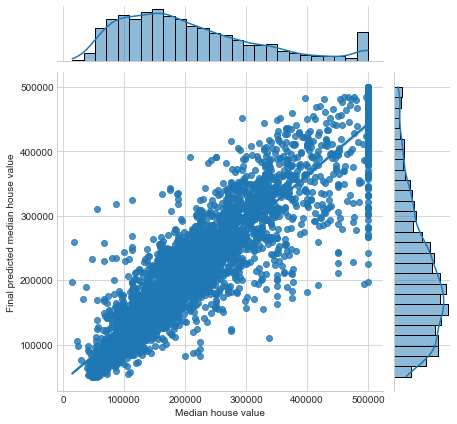

In [128]:
j = sns.jointplot(x=y_test,y= final_predictions,
                  kind="reg",ci=95)

j.set_axis_labels(xlabel="Median house value",
                  ylabel="Final predicted median house value")

[Text(0.5, 0, 'Median house value'),
 Text(0, 0.5, 'Final predicted median house value')]

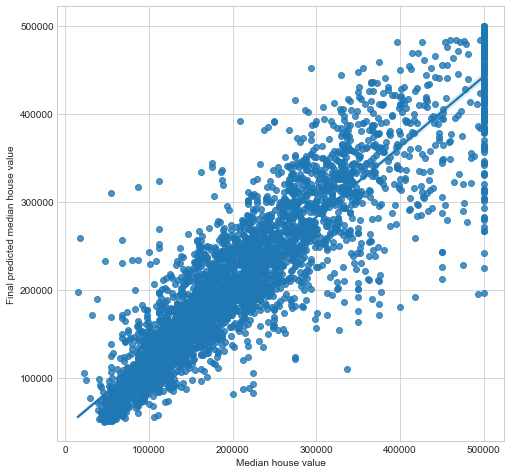

In [129]:
_,ax = plt.subplots(figsize=(8,8))

g = sns.regplot(x=y_test,y= final_predictions,
                ci=95, ## defalut ci: confidence interval 95%
                )
g.set(xlabel="Median house value",
      ylabel="Final predicted median house value")


# Extra material

## A full pipeline with both preparation and prediction

In [130]:
full_pipline_with_preditor = Pipeline([
                    ("preparation",full_pipeline),
                    ("linear",LinearRegression())
            ])

In [131]:
full_pipline_with_preditor.fit(housing,housing_labels)
full_pipline_with_preditor.predict(some_data)

array([203682.37379543, 326371.39370781, 204218.64588245,  58685.4770482 ,
       194213.06443039])

## Example SciPy distributions for `RandomizedSearchCV`

In [132]:
from scipy.stats import geom,expon

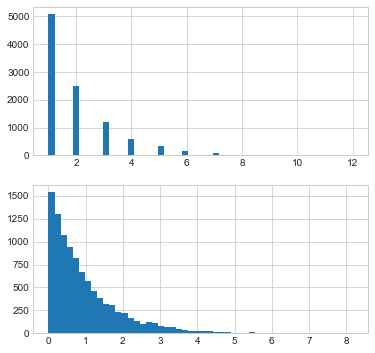

In [133]:
geom_distrib = geom(0.5).rvs(10000,random_state=42)
expon_distrib = expon(scale=1).rvs(10000,random_state=42)

_,ax = plt.subplots(2,1,figsize=(6,6))

ax[0].hist(geom_distrib,bins=50)
ax[1].hist(expon_distrib,bins=50)
plt.show()

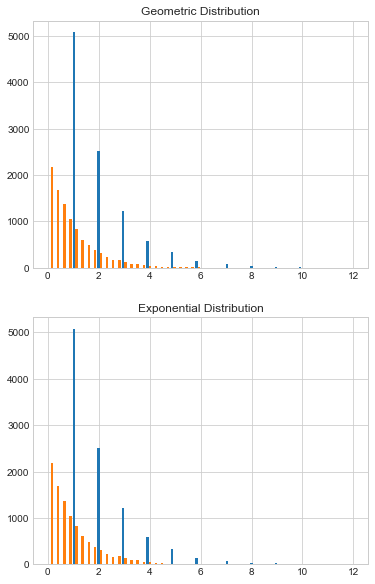

In [134]:
# Modify:

_,axes = plt.subplots(2,1,figsize=(6,10))

titles = ["Geometric Distribution","Exponential Distribution"]
dists = [geom_distrib,expon_distrib]

for ax,dist,title in zip(axes.flatten(),dists,titles):
    ax.hist(dists,bins = 50)
    ax.set(title=title)
plt.show()

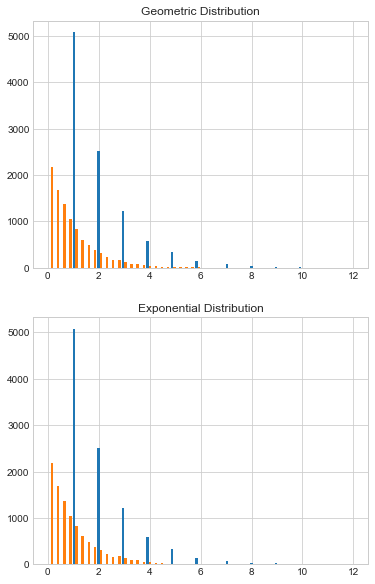

In [135]:
# Modify:

_,axes = plt.subplots(2,1,figsize=(6,10))

titles = ["Geometric Distribution","Exponential Distribution"]
dists = [geom_distrib,expon_distrib]

for ax,dist,title in zip(axes,dists,titles):
    ax.hist(dists,bins = 50)
    ax.set(title=title)
plt.show()

In [136]:
from scipy.stats import expon, reciprocal

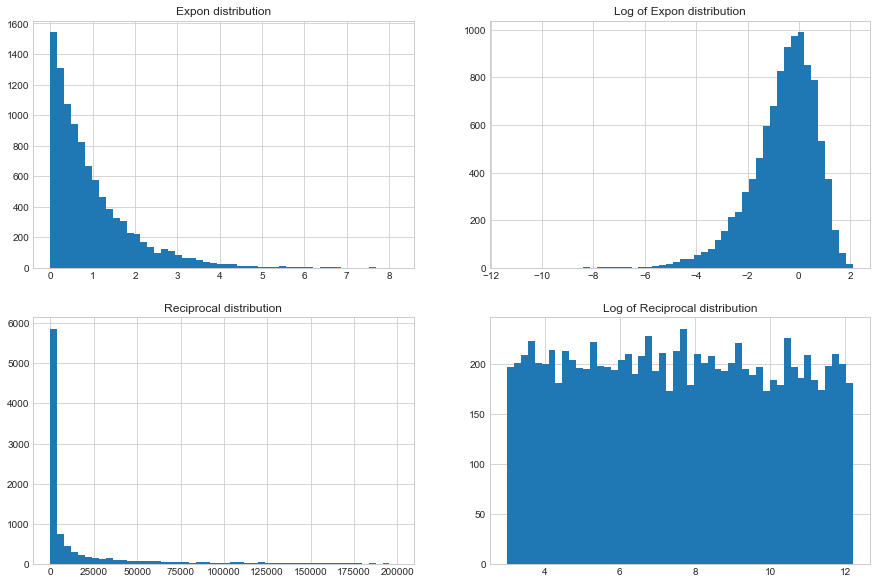

In [137]:
expon_distrib = expon(scale=1).rvs(10000, random_state=42)
reciprocal_distrib = reciprocal(20, 200000).rvs(10000, random_state=42)

_, axes = plt.subplots(2, 2, figsize=(15, 10))

titles = [
    "Expon distribution", "Log of Expon distribution",
    "Reciprocal distribution", "Log of Reciprocal distribution"
]

dists = [
    expon_distrib,
    np.log(expon_distrib), reciprocal_distrib,
    np.log(reciprocal_distrib)
]

for ax, dist, title in zip(axes.flatten(), dists, titles):
    ax.hist(dist, bins=50)
    ax.set(title=title)

plt.show()

# Excercise
## Question: 

Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [138]:
from sklearn.model_selection import GridSearchCV

In [139]:
# param_grid = [
#         {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
#         {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
#          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
#     ]

# svm_reg = SVR()
# grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
# grid_search.fit(housing_prepared, housing_labels)

## Select only the most important attributes

In [140]:
from sklearn.base import BaseEstimator, TransformerMixin

In [141]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])


class TopFeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k

    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances,
                                                 self.k)
        return self

    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [142]:
k = 5

In [143]:
feature_impotances

array([6.38164214e-02, 5.90134455e-02, 4.47758424e-02, 1.68342316e-02,
       1.66053055e-02, 1.67160984e-02, 1.60506893e-02, 2.67564924e-01,
       1.51977877e-01, 3.85965221e-02, 1.08882023e-01, 5.14671296e-02,
       8.12705110e-03, 1.32990677e-01, 8.22987453e-05, 2.42976695e-03,
       4.06969700e-03])

Now let's look for the indices of the top k features:

In [144]:
top_k_feature_indices = indices_of_top_k(feature_impotances,k)
top_k_feature_indices

array([ 0,  7,  8, 10, 13])

In [145]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'median_income', 'income_categories', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

In [146]:
sorted(zip(feature_impotances,attributes),reverse=True)[:k]

[(0.267564924304498, 'median_income'),
 (0.151977876598429, 'income_categories'),
 (0.1329906765954137, 'INLAND'),
 (0.10888202293670339, 'pop_per_hhold'),
 (0.0638164214018482, 'longitude')]

Looking good... Now let's create **a new pipeline** that runs the previously defined :

    1.preparation pipeline;

    2.adds top k feature selection.

In [147]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation',full_pipeline),
    ('feature_selection',TopFeatureSelector(feature_impotances,k))
])

In [148]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [149]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281, -0.61493744, -0.95445595, -0.08649871,  0.        ],
       [-1.17602483,  1.33645936,  1.89030518, -0.03353391,  0.        ],
       [ 1.18684903, -0.5320456 , -0.95445595, -0.09240499,  0.        ]])

In [150]:
housing_prepared[0:3,top_k_feature_indices]

array([[-1.15604281, -0.61493744, -0.95445595, -0.08649871,  0.        ],
       [-1.17602483,  1.33645936,  1.89030518, -0.03353391,  0.        ],
       [ 1.18684903, -0.5320456 , -0.95445595, -0.09240499,  0.        ]])

In [151]:
feature_impotances

array([6.38164214e-02, 5.90134455e-02, 4.47758424e-02, 1.68342316e-02,
       1.66053055e-02, 1.67160984e-02, 1.60506893e-02, 2.67564924e-01,
       1.51977877e-01, 3.85965221e-02, 1.08882023e-01, 5.14671296e-02,
       8.12705110e-03, 1.32990677e-01, 8.22987453e-05, 2.42976695e-03,
       4.06969700e-03])

## Question: 

Try creating a single pipeline that does the full data preparation plus the final prediction.

In [152]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))])

NameError: name 'feature_importances' is not defined